In [2]:
import os
import h5py
import numpy as np
from sklearn import preprocessing
from dppy.finite_dpps import FiniteDPP
from dppy.utils import example_eval_L_linear
from sampling_utils import *

In [3]:
feats_path = '/beegfs/work/sonyc/features/openl3/2017/sonycnode-b827eb132382.sonyc_features_openl3.h5'
indices_path = '/beegfs/work/sonyc/indices/2017/'+ os.path.basename(feats_path).replace('features_openl3', 'recording_index')

num_rows = 5
blob = h5py.File(feats_path)
feats = blob['openl3']['openl3'][:5,:]
ts = blob['openl3']['timestamp'][:5]
feats = feats.reshape(-1, 512)

In [4]:
feats_normalized = preprocessing.normalize(feats, norm='l1')

In [5]:
indices = h5py.File(indices_path)
spl_vecs = indices['recording_index']['spl_vector'][:num_rows,:]

DPP kernel L can be written as a Gram matrix, ${L = B^TB}$, where the columns of B are vectors representing items in the set Y (embeddings). We now take this one step further, writing each column $B_i$ as the product of a quality term
${q_i \in R^+}$ and a vector of normalized diversity features $\phi_i \in R^D$ , $\left\lVert{\phi_i}\right\rVert = 1$

\begin{equation*}
\mathbf{L}_{ij} = q_i \phi_i^T \phi_j q_j
\end{equation*}

We can think of ${q_i \in R^+}$ as measuring the intrinsic 'goodness' of an item i, and ${\phi_i^T \phi_j \in [-1, 1]}$
as a signed measure of similarity between items i and j.

In [16]:
assert ts.shape[0] == spl_vecs.shape[0]
probs = get_rel_loudness_probs(ts, spl_vecs)
q = [probs[i][j] for i in range(probs.shape[0]) for j in range(len(probs[0]))]
q = np.array(q).reshape(-1, 1)

In [7]:
L = q.T * feats_normalized.dot(feats_normalized.T) * q
DPP = FiniteDPP('likelihood', **{'L': L})

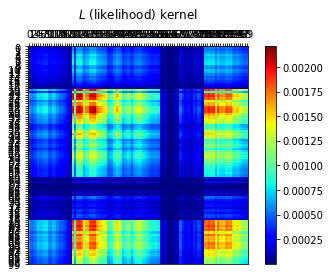

In [8]:
DPP.plot_kernel()

In [8]:
# https://github.com/guilgautier/DPPy/issues/58
# An error is thrown because the initialization failed with initialize_AD_and_E_sampler:
# None of the 100 random k-subsets S0 satisfied the (hard-coded constraint) det L_S0 > 1e-9

# https://github.com/guilgautier/DPPy/blob/dd18c6eacb4702b7627bad128524c278aba65a21/dppy/mcmc_sampling.py#L101

k = 10
rng = np.random.RandomState(413121)
indexes = np.random.choice(feats.shape[0], k, replace=False)
print('det L_rand = ', np.linalg.det(L[np.ix_(indexes, indexes)]))

det L_rand =  2.977534257611701e-49


In [9]:
DPP.flush_samples()
DPP.sample_mcmc_k_dpp(size=k, s_init=indexes, nb_iter=3)
print(DPP.list_of_samples)

[[[4, 29, 12, 54, 9, 20, 6, 22, 76, 18], [4, 29, 12, 54, 9, 20, 6, 22, 76, 18], [4, 29, 12, 54, 9, 20, 6, 22, 76, 18]]]


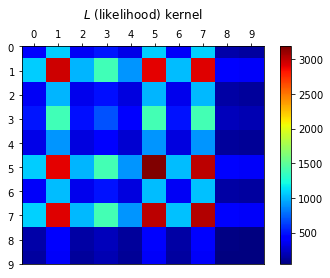

In [17]:
feats_idx = DPP.list_of_samples[0][0]
sel_feats = np.array([feats[x] for x in feats_idx])
sel_q = np.array([q[x] for x in feats_idx])

L = sel_q.T * sel_feats.dot(sel_feats.T) * sel_q 
DPP = FiniteDPP('likelihood', **{'L': L})
DPP.plot_kernel()